# Requirements

In [ ]:
# 네이버 나눔 폰트 설치 
# 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
!pip install transformers

In [ ]:
import json
import random
import os
import torch
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Training Data 준비 및 EDA

In [ ]:
DATA_PATH = "Your Path"

In [ ]:
with open(DATA_PATH + "train.json", 'rb') as f:
    data_dict = json.load(f)

In [ ]:
data_dict["data"][0]

{'news_category': '종합',
 'paragraphs': [{'context': '올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은 이달 말께 장마가 시작될 전망이다.17일 기상청에 따르면 제주도 남쪽 먼바다에 있는 장마전선의 영향으로 이날 제주도 산간 및 내륙지역에 호우주의보가 내려지면서 곳곳에 100㎜에 육박하는 많은 비가 내렸다. 제주의 장마는 평년보다 2~3일, 지난해보다는 하루 일찍 시작됐다. 장마는 고온다습한 북태평양 기단과 한랭 습윤한 오호츠크해 기단이 만나 형성되는 장마전선에서 내리는 비를 뜻한다.장마전선은 18일 제주도 먼 남쪽 해상으로 내려갔다가 20일께 다시 북상해 전남 남해안까지 영향을 줄 것으로 보인다. 이에 따라 20~21일 남부지방에도 예년보다 사흘 정도 장마가 일찍 찾아올 전망이다. 그러나 장마전선을 밀어올리는 북태평양 고기압 세력이 약해 서울 등 중부지방은 평년보다 사나흘가량 늦은 이달 말부터 장마가 시작될 것이라는 게 기상청의 설명이다. 장마전선은 이후 한 달가량 한반도 중남부를 오르내리며 곳곳에 비를 뿌릴 전망이다. 최근 30년간 평균치에 따르면 중부지방의 장마 시작일은 6월24~25일이었으며 장마기간은 32일, 강수일수는 17.2일이었다.기상청은 올해 장마기간의 평균 강수량이 350~400㎜로 평년과 비슷하거나 적을 것으로 내다봤다. 브라질 월드컵 한국과 러시아의 경기가 열리는 18일 오전 서울은 대체로 구름이 많이 끼지만 비는 오지 않을 것으로 예상돼 거리 응원에는 지장이 없을 전망이다.',
   'qas': [{'answers': [{'answer_start': 478, 'text': '한 달가량'},
      {'answer_start': 478, 'text': '한 달'}],
     'guid': '798db07f0b9046759deed9d4a35ce31e',
     'question': '북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?'}]}]

In [ ]:
def read_data(path):
    with open(path, 'rb') as f:
        data_dict = json.load(f)

    categories = [] 
    contexts = []
    questions = []
    answers = []

    for group in tqdm(data_dict['data']):
        category = group["news_category"]  
        
        for passage in group['paragraphs']:
            context = passage['context']

            for qa in passage['qas']:
                question = qa['question']

                for answer in qa['answers']: 

                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
                    categories.append(category)
  

    return categories, contexts, questions, answers

In [ ]:
def add_end_idx(answers, contexts):
  
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']

        end_idx = start_idx + len(gold_text)

        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx

        # (아마) 띄어쓰기 고려
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1

        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2

In [ ]:
train_categories, train_contexts, train_questions, train_answers = read_data(DATA_PATH + "train.json")
add_end_idx(train_answers, train_contexts)

  0%|          | 0/9789 [00:00<?, ?it/s]

- tokenization 진행 전 데이터 분포

In [ ]:
train_df = pd.DataFrame()
train_df['Categories'] = train_categories
train_df['Contexts'] = train_contexts
train_df['Questions'] = train_questions
train_df['Answers'] = train_answers

In [ ]:
train_df.describe(include="all")

,Categories,Contexts,Questions,Answers
count,12667,17663,17663,17663
unique,33,10434,12037,17463
top,종합,신격호 롯데그룹 총괄회장(94)이 롯데그룹 경영권 분쟁과 관련해 장남인 신동주 전 ...,"롯데의 경영권 후계자 임명과 관련, 신 총괄회장과의 최초 공개 인터뷰가 있었던 장소는?","{'text': '2008년', 'answer_start': 0, 'answer_e..."
freq,2425,11,11,3


In [ ]:
train_df.head()

,Categories,Contexts,Questions,Answers
0,종합,올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?,"{'text': '한 달가량', 'answer_start': 478, 'answer..."
1,종합,올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?,"{'text': '한 달', 'answer_start': 478, 'answer_e..."
2,경제,부산시와 (재)부산정보산업진흥원(원장 이인숙)이 ‘2020~2021년 지역SW서비스...,지능형 생산자동화 기반기술을 개발중인 스타트업은?,"{'text': '삼보테크놀로지', 'answer_start': 1422, 'ans..."
3,None,시범 경기에서는 16이닝을 던져 15실점을 기록하는 등 성적이 좋지 않았지만 본인으...,개막전에서 3안타 2실점을 기록해서 패한 선수는?,"{'text': '와쿠이 히데아키', 'answer_start': 107, 'ans..."
4,생활경제,유명 맛집 이름을 달고 나온 편의점 자체상표(PB) 라면이 인기를 끌고 있다. ‘검...,컵라면 매출에서 불닭볶음면을 이긴 상품은?,"{'text': '‘교동반점 짬뽕’', 'answer_start': 408, 'an..."


## 중복

In [ ]:
Answers_str = train_df['Answers'].apply(str)
temp_train_df = train_df.copy()
temp_train_df["Answers"] = Answers_str
temp_train_df.head()

,Categories,Contexts,Questions,Answers
0,종합,올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?,"{'text': '한 달가량', 'answer_start': 478, 'answer..."
1,종합,올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?,"{'text': '한 달', 'answer_start': 478, 'answer_e..."
2,경제,부산시와 (재)부산정보산업진흥원(원장 이인숙)이 ‘2020~2021년 지역SW서비스...,지능형 생산자동화 기반기술을 개발중인 스타트업은?,"{'text': '삼보테크놀로지', 'answer_start': 1422, 'ans..."
3,None,시범 경기에서는 16이닝을 던져 15실점을 기록하는 등 성적이 좋지 않았지만 본인으...,개막전에서 3안타 2실점을 기록해서 패한 선수는?,"{'text': '와쿠이 히데아키', 'answer_start': 107, 'ans..."
4,생활경제,유명 맛집 이름을 달고 나온 편의점 자체상표(PB) 라면이 인기를 끌고 있다. ‘검...,컵라면 매출에서 불닭볶음면을 이긴 상품은?,"{'text': '‘교동반점 짬뽕’', 'answer_start': 408, 'an..."


In [ ]:
print(len(temp_train_df[temp_train_df.duplicated(keep=False)].sort_values("Contexts")))
temp_train_df[temp_train_df.duplicated(keep=False)].sort_values("Contexts")

10


,Categories,Contexts,Questions,Answers
10923,기획,"‘기업공개(IPO) 수 105건, 조달금액 7억3100만유로(약 1조900억원).’...",자기자본을 가지고 금융거래하는 것을 막은 미국의 법안은?,"{'text': '한국경제신문', 'answer_start': 288, 'answe..."
10924,기획,"‘기업공개(IPO) 수 105건, 조달금액 7억3100만유로(약 1조900억원).’...",자기자본을 가지고 금융거래하는 것을 막은 미국의 법안은?,"{'text': '한국경제신문', 'answer_start': 288, 'answe..."
14464,None,"중동신도시(中洞新都市)는 경기도 부천시 중동, 상동 일대에 조성된 신도시이다. 중동...",중동신도시 개발에 기관 몇 곳이 적극적으로 뛰어들었나?,"{'text': '3', 'answer_start': 386, 'answer_end..."
14466,None,"중동신도시(中洞新都市)는 경기도 부천시 중동, 상동 일대에 조성된 신도시이다. 중동...",중동신도시 개발에 기관 몇 곳이 적극적으로 뛰어들었나?,"{'text': '3', 'answer_start': 386, 'answer_end..."
1403,금융,직장인 H씨는 연말에 받는 1000만원가량의 성과급과 만기가 된 적금 2500만원을...,지방은행이 특별판매를 하는 이유는?,"{'text': '연말에 만기가 돌아오는 예금 가입자들을 유치하기 위해서', 'an..."
1406,금융,직장인 H씨는 연말에 받는 1000만원가량의 성과급과 만기가 된 적금 2500만원을...,지방은행이 특별판매를 하는 이유는?,"{'text': '연말에 만기가 돌아오는 예금 가입자들을 유치하기 위해서', 'an..."
11140,산업,코오롱그룹 IT서비스 전문기업 코오롱베니트(대표 이진용)가 오는 20일부터 24일까...,Smart Construction & IoT의 현황과 전망'을 주제로한 솔루션 구축...,"{'text': '20일', 'answer_start': 36, 'answer_en..."
11142,산업,코오롱그룹 IT서비스 전문기업 코오롱베니트(대표 이진용)가 오는 20일부터 24일까...,Smart Construction & IoT의 현황과 전망'을 주제로한 솔루션 구축...,"{'text': '20일', 'answer_start': 36, 'answer_en..."
1260,None,흑표당은 스토클리 카마이클이 주도하는 학생 비폭력 협력회와 합병되었다. 1968년 ...,흑표당이 실현하고자 했던 말콤X의 사상은?,"{'text': '자기방어 철학', 'answer_start': 281, 'answ..."
1262,None,흑표당은 스토클리 카마이클이 주도하는 학생 비폭력 협력회와 합병되었다. 1968년 ...,흑표당이 실현하고자 했던 말콤X의 사상은?,"{'text': '자기방어 철학', 'answer_start': 281, 'answ..."


## 비슷한 의미의 Question

In [ ]:
temp_train_df[temp_train_df.duplicated(["Questions"],keep=False)].sort_values("Contexts")

,Categories,Contexts,Questions,Answers
15074,None,"""시간이동""은 미국의 방송사 ABC의 텔레비전 드라마 시리즈 로스트의 시즌 프리미어...",ABC에서 방영되는 '시간이동'의 장르는?,"{'text': '텔레비전 드라마', 'answer_start': 21, 'answ..."
15075,None,"""시간이동""은 미국의 방송사 ABC의 텔레비전 드라마 시리즈 로스트의 시즌 프리미어...",ABC에서 방영되는 '시간이동'의 장르는?,"{'text': '드라마', 'answer_start': 26, 'answer_en..."
14154,None,"""아자르야""라는 이름은 ""여호와는 나의 힘이다""라는 의미를 가지고 있다. 예루살렘 ...",아자르야에게 패배한 아랍인들의 거주지 중 아자르야가 새롭게 성을 쌓은 지역은 어디인가?,"{'text': '팔레스타인', 'answer_start': 189, 'answer..."
14153,None,"""아자르야""라는 이름은 ""여호와는 나의 힘이다""라는 의미를 가지고 있다. 예루살렘 ...",아자르야에게 패배한 아랍인들의 거주지 중 아자르야가 새롭게 성을 쌓은 지역은 어디인가?,"{'text': '블레셋(팔레스타인) 지역', 'answer_start': 185,..."
14152,None,"""아자르야""라는 이름은 ""여호와는 나의 힘이다""라는 의미를 가지고 있다. 예루살렘 ...",아자르야에게 패배한 아랍인들의 거주지 중 아자르야가 새롭게 성을 쌓은 지역은 어디인가?,"{'text': '블레셋(팔레스타인)', 'answer_start': 185, 'a..."
...,...,...,...,...
4350,None,"힐은 전쟁중에 논쟁을 피하지 못했다. 병약한 체질이라서 여러 번 병치레를 했기에, ...",남군의 소장들 중 힐이 가장 뛰어난 사람이라고 언급한 인물은?,"{'text': '로버트 E. 리', 'answer_start': 820, 'ans..."
9612,경제,＃1. 중국 항저우에 사는 진옌 씨(37)는 다음달 춘제(春節·중국 설) 연휴에 부...,현재 중국인 관광객이 한국을 재방문하는 비율은 약 몇 %인가요?,"{'text': '30', 'answer_start': 1092, 'answer_e..."
9611,경제,＃1. 중국 항저우에 사는 진옌 씨(37)는 다음달 춘제(春節·중국 설) 연휴에 부...,현재 중국인 관광객이 한국을 재방문하는 비율은 약 몇 %인가요?,"{'text': '30%', 'answer_start': 1092, 'answer_..."
9610,경제,＃1. 중국 항저우에 사는 진옌 씨(37)는 다음달 춘제(春節·중국 설) 연휴에 부...,일본이 최근 취한 비자완화 조치 대상이 되는 유커는?,"{'text': '상당한 고소득자와 그 가족', 'answer_start': 870..."


## Domain Distribution

In [ ]:
category_df = temp_train_df['Categories'].value_counts().rename_axis('unique_values').reset_index(name='counts')

In [ ]:
category_df.head()

,unique_values,counts
0,종합,2425
1,사회,945
2,산업섹션,789
3,국제,781
4,부동산,755


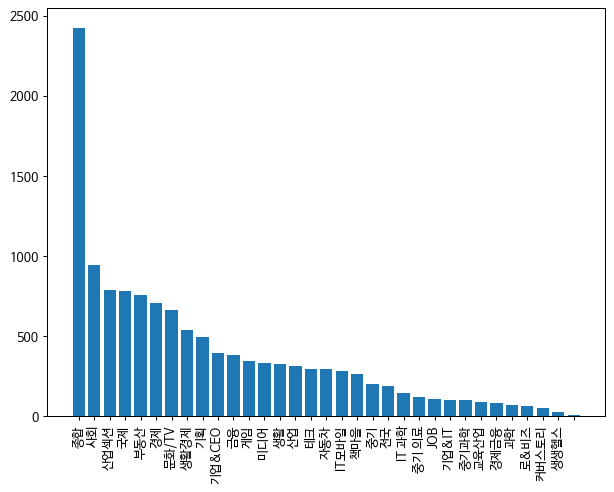

In [ ]:
warnings.filterwarnings("ignore")
figure(figsize=(8, 6), dpi=90)
plt.bar(category_df.unique_values, category_df.counts)
plt.xticks(rotation=90)
plt.show()

## 문장 길이

### Contexts

In [ ]:
def get_length(df):
  context_list = []
  question_list = []
  context_question_list = []
  answer_list = []

  for _, row in train_df.iterrows():
    context_len = len(row.Contexts)
    question_len = len(row.Questions)

    context_list.append(context_len)
    question_list.append(question_len)
    context_question_list.append(context_len + question_len)

    try:
      answer_length = len(row.Answers["text"])
      answer_list.append(answer_length)

    except: 
      pass

  return context_list, question_list, context_question_list, answer_list

In [ ]:
train_context_list, train_question_list, train_context_question_list, train_answer_list = get_length(train_df)

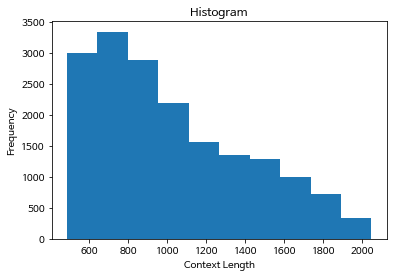

In [ ]:
n, bins, patches=plt.hist(train_context_list)
plt.xlabel("Context Length")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

### Questions

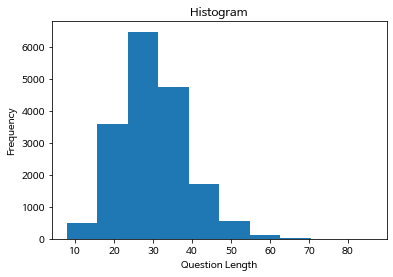

In [ ]:
n, bins, patches=plt.hist(train_question_list)
plt.xlabel("Question Length")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

### Contexts + Questions

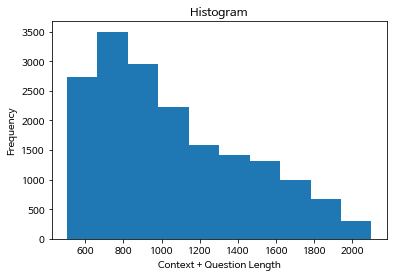

In [ ]:
n, bins, patches=plt.hist(train_context_question_list)
plt.xlabel("Context + Question Length")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

### Answers

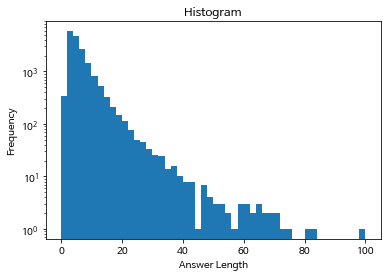

In [ ]:
n, bins, patches=plt.hist(train_answer_list, bins=50, log=True, range=[0,100])
plt.xlabel("Answer Length")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

# 전처리 

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

In [ ]:
pretrained_vocabs = tokenizer.get_vocab()

In [ ]:
# # sort by token id 
dict(sorted(pretrained_vocabs.items(), key=lambda item: item[1]))

{'[PAD]': 0,
 '[UNK]': 1,
 '[CLS]': 2,
 '[SEP]': 3,
 '[MASK]': 4,
 '!': 5,
 '"': 6,
 '#': 7,
 '$': 8,
 '%': 9,
 '&': 10,
 "'": 11,
 '(': 12,
 ')': 13,
 '*': 14,
 '+': 15,
 ',': 16,
 '-': 17,
 '.': 18,
 '/': 19,
 '0': 20,
 '1': 21,
 '2': 22,
 '3': 23,
 '4': 24,
 '5': 25,
 '6': 26,
 '7': 27,
 '8': 28,
 '9': 29,
 ':': 30,
 ';': 31,
 '<': 32,
 '=': 33,
 '>': 34,
 '?': 35,
 '@': 36,
 'A': 37,
 'B': 38,
 'C': 39,
 'D': 40,
 'E': 41,
 'F': 42,
 'G': 43,
 'H': 44,
 'I': 45,
 'J': 46,
 'K': 47,
 'L': 48,
 'M': 49,
 'N': 50,
 'O': 51,
 'P': 52,
 'Q': 53,
 'R': 54,
 'S': 55,
 'T': 56,
 'U': 57,
 'V': 58,
 'W': 59,
 'X': 60,
 'Y': 61,
 'Z': 62,
 '[': 63,
 ']': 64,
 '^': 65,
 '_': 66,
 '`': 67,
 'a': 68,
 'b': 69,
 'c': 70,
 'd': 71,
 'e': 72,
 'f': 73,
 'g': 74,
 'h': 75,
 'i': 76,
 'j': 77,
 'k': 78,
 'l': 79,
 'm': 80,
 'n': 81,
 'o': 82,
 'p': 83,
 'q': 84,
 'r': 85,
 's': 86,
 't': 87,
 'u': 88,
 'v': 89,
 'w': 90,
 'x': 91,
 'y': 92,
 'z': 93,
 '{': 94,
 '|': 95,
 '}': 96,
 '~': 97,
 '²': 98,

## Special Tokens 확인

<tokenization 후 얻을 수 있는 input_ids 에 대한 token 정보>
- '[PAD]': 0,
- '[UNK]': 1,
- '[CLS]': 2,
- '[SEP]': 3,
- '[MASK]': 4,

## Dataset (Tokenization 포함)

In [ ]:
class CustomedDataset(Dataset):

    def __init__(self, contexts, questions, answers, model_max_position_embedings, tokenizer):
        self.tokenizer = tokenizer
        self.answers = answers
        self.questions = questions
        self.contexts = contexts
        self.model_max_position_embedings = model_max_position_embedings
        print("Tokenizing ...")
        self.encodings = self.tokenizer(self.contexts, 
                                        self.questions,
                                        max_length=self.model_max_position_embedings, 
                                        truncation=True,
                                        padding="max_length",
                                        return_token_type_ids=False)
        print("Done !!!")
        self.add_token_positions() 

    def add_token_positions(self):
        start_positions = []
        end_positions = []

        for i in range(len(self.answers)): 
            start_positions.append(self.encodings.char_to_token(i, self.answers[i]['answer_start']))
            end_positions.append(self.encodings.char_to_token(i, self.answers[i]['answer_end'] - 1))
            # import pdb
            # pdb.set_trace()
            if start_positions[-1] is None:
                start_positions[-1] = self.model_max_position_embedings
            if end_positions[-1] is None:
                end_positions[-1] = self.model_max_position_embedings

        self.encodings.update({'start_positions': start_positions, 'end_positions': end_positions})


    def get_data(self):
        return {"contexts":self.contexts, 'questions':self.questions, 'answers':self.answers}
    

    def __getitem__(self, idx):
        return {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
    

    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
train_dataset = CustomedDataset(train_contexts, train_questions, train_answers, 512, tokenizer)

Tokenizing ...
Done !!!


- input_ids: tokenization 결과 + SPECIAL tokens 추가된 형태
- token_type_ids: context 가 0, question이 1
- attention_mask: 모두 1

## Token 개수 & Unknown token 개수 확인 

In [ ]:
# #tokens
def get_token_nums(dataset): 
  length_list = []
  for i in range(len(dataset)):
    length_list.append(dataset.__getitem__(i)["input_ids"].count_nonzero().item())
  return length_list

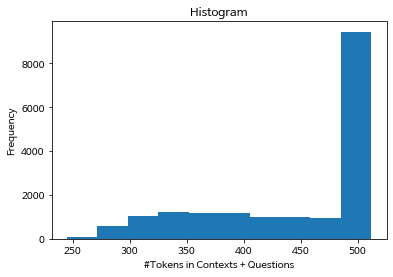

In [ ]:
train_length_list = get_token_nums(train_dataset)

n, bins, patches=plt.hist(train_length_list)
plt.xlabel("#Tokens in Contexts + Questions")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

In [ ]:
def get_one_nums(dataset): 
  one_num_list = []
  for i in range(len(dataset)):
    record_token_ids = dataset.__getitem__(i)["input_ids"]
    num_ones = (record_token_ids == 1.).sum(dim=0).item()
    one_num_list.append(num_ones)
  return one_num_list

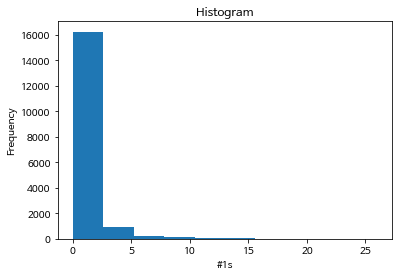

In [ ]:
# unknown tokens
train_one_num_list = get_one_nums(train_dataset)

n, bins, patches=plt.hist(train_one_num_list)
plt.xlabel("#1s")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

In [ ]:
train_one_num_list.count(0) / len(train_one_num_list)

0.7576855573798336

cf. 밑의 코드들은 512로 자르지 않았을 경우

In [ ]:
temp_train_dataset = CustomedDataset(train_contexts, train_questions, train_answers, 2000, tokenizer)

Tokenizing ...
Done !!!


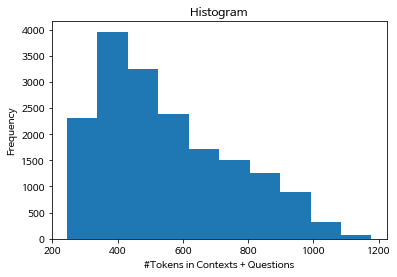

In [ ]:
# #tokens
temp_train_length_list = get_token_nums(temp_train_dataset)

n, bins, patches=plt.hist(temp_train_length_list)
plt.xlabel("#Tokens in Contexts + Questions")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

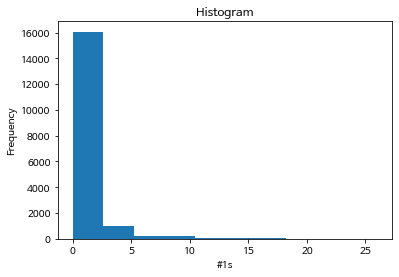

In [ ]:
# unknown tokens
temp_train_one_num_list = get_one_nums(temp_train_dataset)

n, bins, patches=plt.hist(temp_train_one_num_list)
plt.xlabel("#1s")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

In [ ]:
temp_train_one_num_list.count(0)

12951

# Test Data 준비 및 EDA

In [ ]:
def read_test_data(path):
    with open(path, 'rb') as f:
        data_dict = json.load(f)

    categories = [] 
    contexts = []
    questions = []
    guids = [] 

    for group in tqdm(data_dict['data']):
        category = group["news_category"] 

        for passage in group['paragraphs']:
            context = passage['context']

            for qa in passage['qas']:
                question = qa['question']
                guid = qa['guid']

                contexts.append(context)
                questions.append(question)
                guids.append(guid)
                categories.append(category)


    return categories, contexts, questions, guids

In [ ]:
test_categories, test_contexts, test_questions, test_guids = read_test_data(DATA_PATH + "test.json")

  0%|          | 0/3709 [00:00<?, ?it/s]

- tokenization 진행 전 데이터 분포

In [ ]:
test_df = pd.DataFrame()
test_df['Categories'] = test_categories
test_df['Contexts'] = test_contexts
test_df['Questions'] = test_questions
test_df['guid'] = test_guids

In [ ]:
test_df.describe(include="all")

,Categories,Contexts,Questions,guid
count,2818,4008,4008,4008
unique,32,3841,4008,4008
top,종합,호라티우스의 출신 가문은 정확히 알려져 있지 않다. 아마 그의 아버지는 노예에서 해...,다음 해 소형차 시장의 유망주로 예상되는 인도의 자동차 회사는?,c4671b0d6130481899b7879a8a4c073d
freq,515,3,1,1


## 중복, 비슷한 의미의 Question X

In [ ]:
# duplicates
print(len(test_df[test_df.duplicated(keep=False)].sort_values("Contexts")))
test_df[test_df.duplicated(keep=False)].sort_values("Contexts")

0


,Categories,Contexts,Questions,guid


In [ ]:
test_df[test_df.duplicated(["Questions"],keep=False)].sort_values("Contexts")

,Categories,Contexts,Questions,guid


## Domain Distribution:Train 과 비슷

In [ ]:
test_category_df = test_df['Categories'].value_counts().rename_axis('unique_values').reset_index(name='counts')

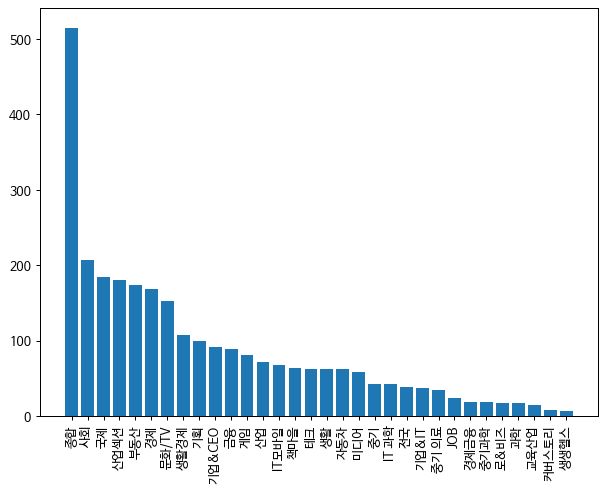

In [ ]:
warnings.filterwarnings("ignore")
figure(figsize=(8, 6), dpi=90)
plt.bar(test_category_df.unique_values, test_category_df.counts)
plt.xticks(rotation=90)
plt.show()

## 문장 길이

### Contexts

In [ ]:
test_context_list, test_question_list, test_context_question_list, _ = get_length(test_df)

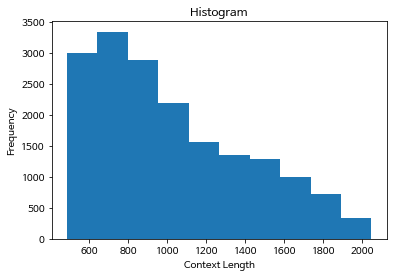

In [ ]:
n, bins, patches=plt.hist(test_context_list)
plt.xlabel("Context Length")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

### Questions

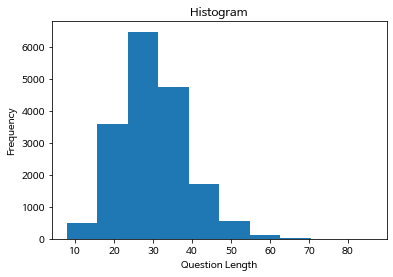

In [ ]:
n, bins, patches=plt.hist(test_question_list)
plt.xlabel("Question Length")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

### Contexts + Questions

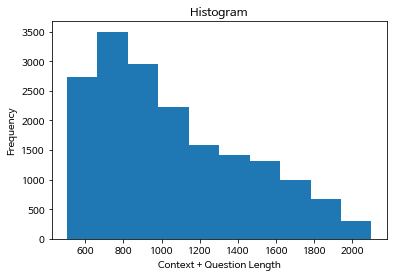

In [ ]:
n, bins, patches=plt.hist(test_context_question_list)
plt.xlabel("Context + Question Length")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

In [ ]:
class Test_Dataset(Dataset):

    def __init__(self, contexts, questions, guids, model_max_position_embedings, tokenizer):
        self.tokenizer = tokenizer
        self.questions = questions
        self.contexts = contexts
        self.guids = guids
        self.model_max_position_embedings = model_max_position_embedings
        print("Tokenizing ...")
        self.encodings = self.tokenizer(self.contexts, 
                                        self.questions,
                                        max_length=self.model_max_position_embedings, 
                                        truncation=True,
                                        padding="max_length",
                                        return_token_type_ids=False)
        print("Done !!!")

    def get_data(self):
        return {"contexts":self.contexts, 'questions':self.questions, 'guids':self.guids}
    

    def __getitem__(self, idx):
        return {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
    

    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
temp_test_dataset = Test_Dataset(test_contexts, test_questions, test_guids, 512, tokenizer)

Tokenizing ...
Done !!!


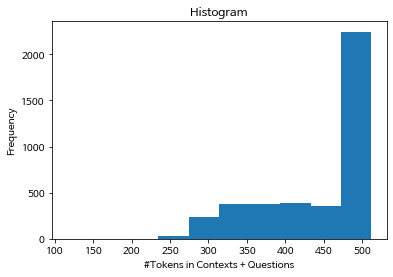

In [ ]:
# tokens
temp_test_length_list = get_token_nums(temp_test_dataset)

n, bins, patches=plt.hist(temp_test_length_list)
plt.xlabel("#Tokens in Contexts + Questions")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

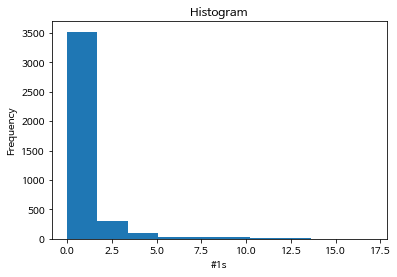

In [ ]:
# unknown tokens
temp_test_one_num_list = get_one_nums(temp_test_dataset)

n, bins, patches=plt.hist(temp_test_one_num_list)
plt.xlabel("#1s")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()